# GRU in Keras

In this notebook, we use a GRU to classify IMDB movie reviews by their sentiment.

In [1]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,pandas,matplotlib,nltk,sklearn,tensorflow,theano,mxnet,chainer,seaborn,keras,tflearn,bokeh,gensim

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/conda/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL
Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:211: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  arg_spec = inspect.getargspec(func)
/opt/conda/lib/python3.6/site-packages/tensorflow/contrib/labeled_tensor/python/ops/_typecheck.py:233: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  spec = inspect.getargspec(f)
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/function.py:810: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(func

Gopala KR 
last updated: 2018-02-19 

CPython 3.6.3
IPython 6.2.1

watermark 1.6.0
numpy 1.12.1
pandas 0.19.2
matplotlib 2.0.2
nltk 3.2.4
sklearn 0.18.2
tensorflow 1.0.0
theano 1.0.1
mxnet 1.0.0
chainer 3.3.0
seaborn 0.7.1
keras 2.0.8
tflearn n
bokeh 0.12.13
gensim 2.3.0


/opt/conda/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


#### Load dependencies

In [2]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import GRU # new! 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

#### Set hyperparameters

In [3]:
# output directory name:
output_dir = 'model_output/gru'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 100 # lowered due to vanishing gradient over time
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# GRU layer architecture:
n_gru = 256 
drop_gru = 0.2

# dense layer architecture: 
# n_dense = 256
# dropout = 0.2

#### Load data

In [4]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17432576/17464789 [============================>.] - ETA: 0s

#### Preprocess data

In [5]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [6]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(GRU(n_gru, dropout=drop_gru))
# model.add(Dense(n_dense, activation='relu')) # typically don't see top dense layer in NLP like in 
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [7]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               246528    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 886,785
Trainable params: 886,785
Non-trainable params: 0
_________________________________________________________________


#### Configure model

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [10]:
# XXX% validation accuracy in epoch X
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 165s - loss: 0.5739 - acc: 0.6918 - val_loss: 0.3760 - val_acc: 0.8392
Epoch 2/4
25000/25000 [==============================] - 169s - loss: 0.3161 - acc: 0.8674 - val_loss: 0.3505 - val_acc: 0.8466
Epoch 3/4
25000/25000 [==============================] - 172s - loss: 0.2508 - acc: 0.9004 - val_loss: 0.3566 - val_acc: 0.8470
Epoch 4/4
25000/25000 [==============================] - 172s - loss: 0.2117 - acc: 0.9185 - val_loss: 0.4295 - val_acc: 0.8339


#### Evaluate

In [11]:
model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [12]:
y_hat = model.predict_proba(x_valid)

24992/25000 [============================>.] - ETA: 0s

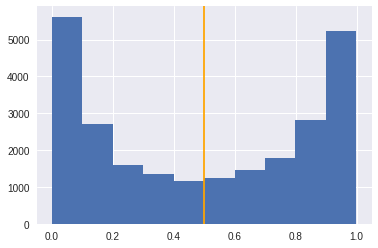

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'92.52'